#NOTE: this work is done in google collab 

In [53]:
!pip install eli5
!pip install pdpbox
!pip install shap

     |████████████████████████████████| 358kB 662kB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491616 sha256=4250c2e08120e53d7d7babdad3dcc4de38cd0e5b4dcbd7f4c7d5d999f7342ce8
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [54]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV

import eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots
import shap

sns.set_theme(style="darkgrid")

# Load Data & Best Models

In [5]:
root='/content/drive/MyDrive/ML Project/heart_disease'
raw_train = pd.read_csv(f'{root}/train.csv')
raw_target = pd.read_csv(f'{root}/target.csv')

tmp_file=open(f"{root}/complete_data_dict.pkl", "rb")
complete_dict_data=pickle.load(tmp_file)

In [6]:
"""load mlp model"""
temp_file=open(f"{root}/mlp_params.pkl", "rb")
best_params_mlp, best_scores_mlp, best_model_mlp, best_matrix_mlp, best_roc_mlp, best_pre_rec_mlp = pickle.load(temp_file)

In [7]:
"""load xgb model"""
temp_file=open(f"{root}/xgb_best_params.pkl", "rb")
best_params_xgb, best_scores_xgb, best_model_xgb, best_matrix_xgb, best_roc_xgb, best_pre_rec_xgb = pickle.load(temp_file)

In [8]:
scaler_xgb='max_min_data'
xgb_model = best_model_xgb[scaler_xgb]
xgb_model

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=nan, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=123, reg_alpha=0,
                                     reg_lambda=1, scale_p...
             iid=None, n_jobs=-1,
             param_grid={'base_score': [0.1, 0.2, 0.3, 0.5], 'gamma': [0.001],
                         'importance_type': ['gain'],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [2, 3, 5],
                         'n_estimators'

# Permutation Importance Analysis

In [19]:
"""load best mlp model"""
scaler_mlp='standardized_data'
X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp = train_test_split(complete_dict_data[scaler_mlp], raw_target, train_size=0.7, random_state=123, shuffle=True)
best_params_mlp[scaler_mlp]

{'activation': 'logistic',
 'alpha': 0.01,
 'batch_size': 100,
 'hidden_layer_sizes': 200,
 'max_iter': 400}

In [20]:
mlp_classifier = MLPClassifier(
    solver='adam',
    learning_rate='adaptive',
    learning_rate_init=0.001,
    shuffle=True,
    random_state=123,
    tol=1e-4,
    verbose=True,
    warm_start=False, 
    validation_fraction=0.1,
    n_iter_no_change=15,
    activation='logistic',
    alpha=0.01,
    batch_size=100,
    hidden_layer_sizes=(200,),
    max_iter=400)
mlp_classifier = mlp_classifier.fit(X_train_mlp, y_train_mlp)

Iteration 1, loss = 0.66297701
Iteration 2, loss = 0.65237688
Iteration 3, loss = 0.64216268
Iteration 4, loss = 0.63244896
Iteration 5, loss = 0.62296261
Iteration 6, loss = 0.61414490
Iteration 7, loss = 0.60513830
Iteration 8, loss = 0.59636549
Iteration 9, loss = 0.58772051
Iteration 10, loss = 0.57934509
Iteration 11, loss = 0.57030528
Iteration 12, loss = 0.56165778
Iteration 13, loss = 0.55398262
Iteration 14, loss = 0.54581245
Iteration 15, loss = 0.53783333
Iteration 16, loss = 0.52986808
Iteration 17, loss = 0.52234704
Iteration 18, loss = 0.51489114
Iteration 19, loss = 0.50730926
Iteration 20, loss = 0.50018101
Iteration 21, loss = 0.49318022
Iteration 22, loss = 0.48585636
Iteration 23, loss = 0.47912885
Iteration 24, loss = 0.47211604
Iteration 25, loss = 0.46593942
Iteration 26, loss = 0.45966831
Iteration 27, loss = 0.45371350
Iteration 28, loss = 0.44736102
Iteration 29, loss = 0.44215303
Iteration 30, loss = 0.43613248
Iteration 31, loss = 0.43141176
Iteration 32, los

In [21]:
print(accuracy_score(y_test_mlp, mlp_classifier.predict(X_test_mlp)))

0.8405797101449275


In [12]:
print(best_scores_mlp[scaler_mlp])

{'accuracy': 0.8405797101449275, 'precision': 0.7857142857142857, 'recall': 0.9428571428571428, 'f1-score': 0.8571428571428571, 'auc': 0.8390756302521009, 'avg_precision_score': 0.7698018337769891}


In [69]:
"""load best xgb model"""
scaler_xgb='max_min_data'
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(complete_dict_data[scaler_xgb], raw_target, train_size=0.7, random_state=123, shuffle=True)
best_params_xgb[scaler_xgb]

{'base_score': 0.2,
 'gamma': 0.001,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 100,
 'reg_alpha': 0.1,
 'reg_lambda': 0.1,
 'scale_pos_weight': 1.5}

In [107]:
xgb_classifier = XGBClassifier(objective='binary:logistic', 
                              booster='gbtree', tree_method='auto', 
                              subsample=1,  
                              random_state=123,
                              base_score=0.2,
                              gamma=0.001,
                              importance_type='gain',
                              learning_rate=0.1,
                              max_depth=5,
                              n_estimators=100,
                              reg_alpha=0.1,
                              reg_lambda=0.1,
                              scale_pos_weight=1.5)
xgb_classifer = xgb_classifier.fit(X_train, y_train)

In [108]:
accuracy_score(y_test_xgb, xgb_classifier.predict(X_test_xgb))

0.8405797101449275

In [109]:
best_scores_xgb[scaler_xgb]

{'accuracy': 0.8405797101449275,
 'auc': 0.8386554621848739,
 'avg_precision_score': 0.765142104272539,
 'f1-score': 0.8607594936708862,
 'precision': 0.7727272727272727,
 'recall': 0.9714285714285714}

In [17]:
"""
age: The person's age in years
sex: The person's sex (1 = male, 0 = female)
cp: The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
trestbps: The person's resting blood pressure (mm Hg on admission to the hospital)
chol: The person's cholesterol measurement in mg/dl
fbs: The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)
restecg: Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
thalach: The person's maximum heart rate achieved
exang: Exercise induced angina (1 = yes; 0 = no)
oldpeak: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more here)
slope: the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
ca: The number of major vessels (0-3)
thal: A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
target: Heart disease (0 = no, 1 = yes)
"""
"""feature importance with mlp model"""
perm_mlp = PermutationImportance(mlp_classifier, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm_mlp, feature_names = raw_train.columns.values)

Weight,Feature
0.1014 ± 0.0485,ca
0.0696 ± 0.0646,thal
0.0696 ± 0.0591,cp
0.0638 ± 0.0832,sex
0.0464 ± 0.0338,trestbps
0.0406 ± 0.0338,slope
0.0348 ± 0.0296,chol
0.0290 ± 0.0318,restecg
0.0232 ± 0.0434,oldpeak
0.0116 ± 0.0426,thalach


In [18]:
"""feature importance with xgb model"""
perm_xgb = PermutationImportance(xgb_classifier, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm_xgb, feature_names = raw_train.columns.values)

Weight,Feature
0.1014 ± 0.0318,age
0.0986 ± 0.0591,cp
0.0696 ± 0.0426,thal
0.0435 ± 0.0000,thalach
0.0435 ± 0.0756,oldpeak
0.0406 ± 0.0217,chol
0.0348 ± 0.0296,trestbps
0.0348 ± 0.0393,sex
0.0319 ± 0.0217,slope
0.0261 ± 0.0619,ca


# Feature Importance With Partial Dependence Plot (MLP)

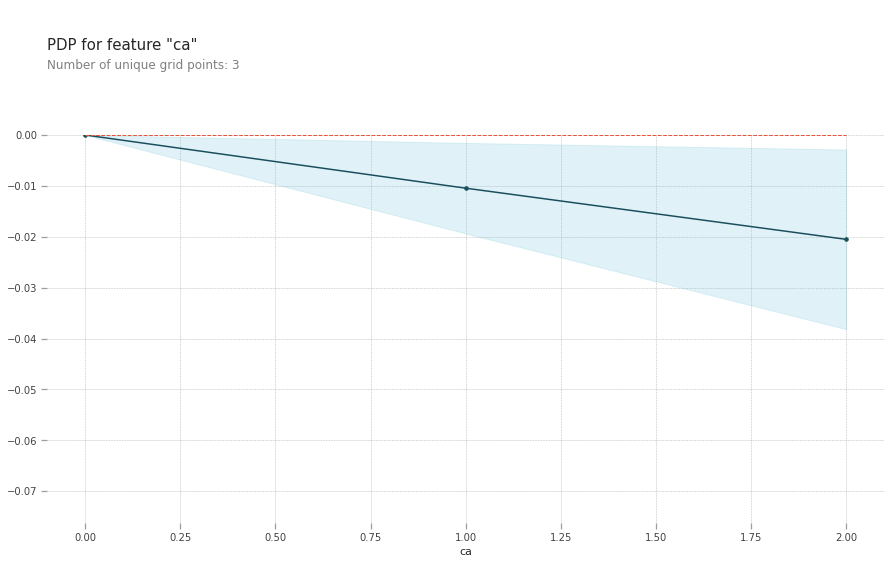

In [48]:
"""PDP for feature 'ca' with MLP model """
feature_name='ca'
pdp_mlp = pdp.pdp_isolate(model=mlp_classifier, dataset=raw_train, model_features=raw_train.columns.values, feature=feature_name)
pdp.pdp_plot(pdp_mlp, feature_name)
plt.show()

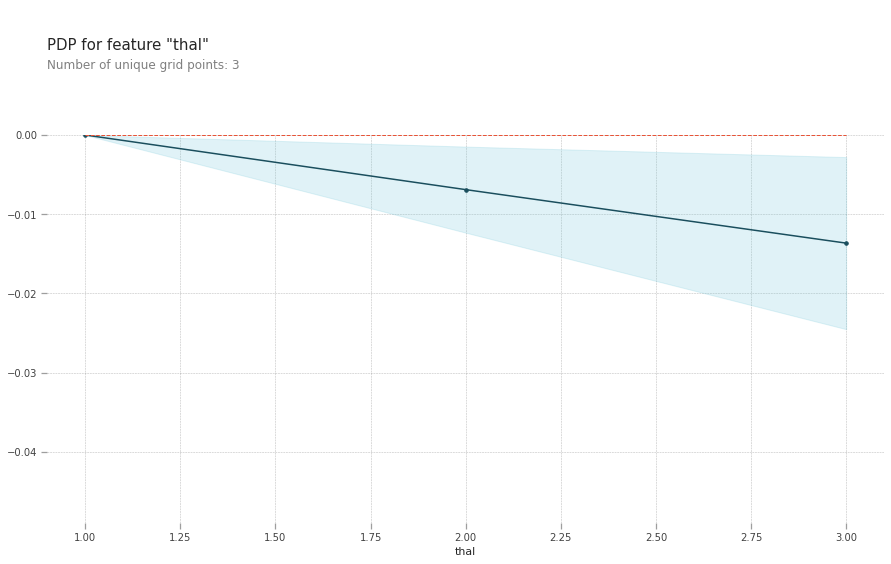

In [49]:
"""PDP for feature 'thal' with MLP model """
feature_name='thal'
pdp_mlp = pdp.pdp_isolate(model=mlp_classifier, dataset=raw_train, model_features=raw_train.columns.values, feature=feature_name)
pdp.pdp_plot(pdp_mlp, feature_name)
plt.show()

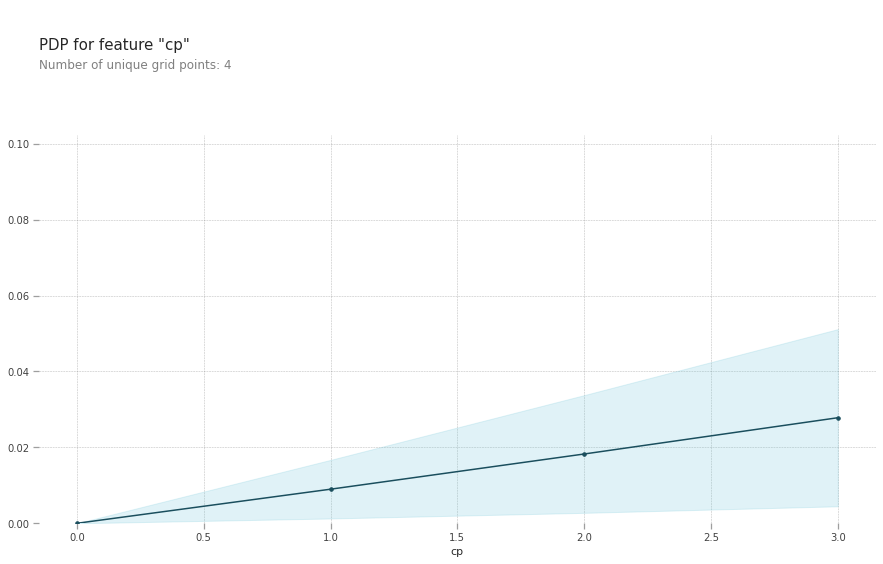

In [50]:
"""PDP for feature 'cp' with MLP model """
feature_name='cp'
pdp_mlp = pdp.pdp_isolate(model=mlp_classifier, dataset=raw_train, model_features=raw_train.columns.values, feature=feature_name)
pdp.pdp_plot(pdp_mlp, feature_name)
plt.show()

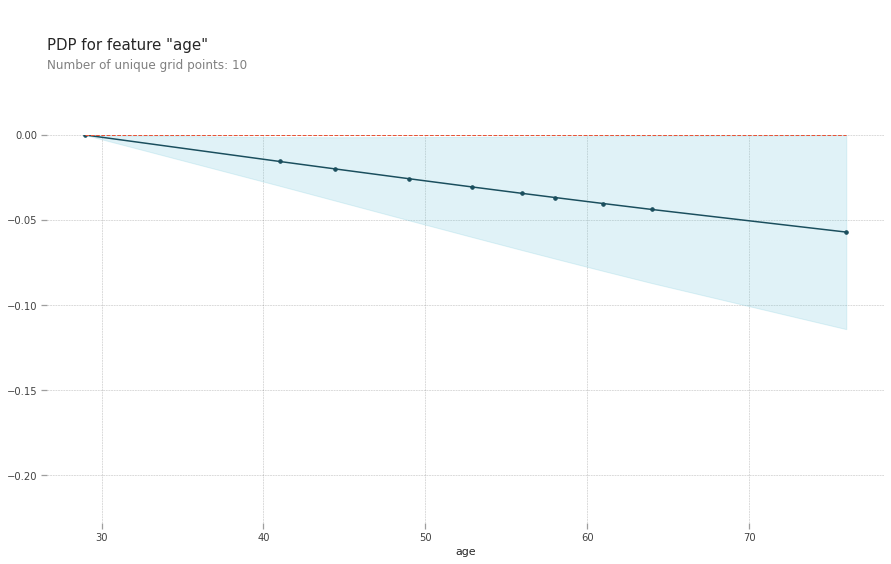

In [51]:
"""PDP for feature 'age' with MLP model """
feature_name='age'
pdp_mlp = pdp.pdp_isolate(model=mlp_classifier, dataset=raw_train, model_features=raw_train.columns.values, feature=feature_name)
pdp.pdp_plot(pdp_mlp, feature_name)
plt.show()

# Feature Importance With SHAP (XGBoost)



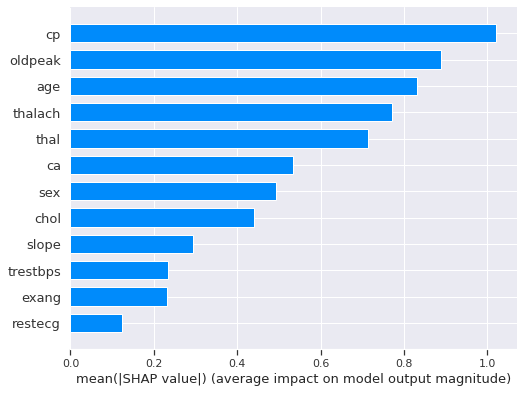

In [123]:
"""
age: The person's age in years
sex: The person's sex (1 = male, 0 = female)
cp: The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
trestbps: The person's resting blood pressure (mm Hg on admission to the hospital)
chol: The person's cholesterol measurement in mg/dl
fbs: The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)
restecg: Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
thalach: The person's maximum heart rate achieved
exang: Exercise induced angina (1 = yes; 0 = no)
oldpeak: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more here)
slope: the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
ca: The number of major vessels (0-3)
thal: A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
target: Heart disease (0 = no, 1 = yes)
"""
explainer = shap.Explainer(xgb_classifier)
shape_values = explainer.shap_values(pd.DataFrame(X_test, columns=raw_train.columns.values))
shap.summary_plot(shap_values, pd.DataFrame(X_test, columns=raw_train.columns.values), plot_type="bar")

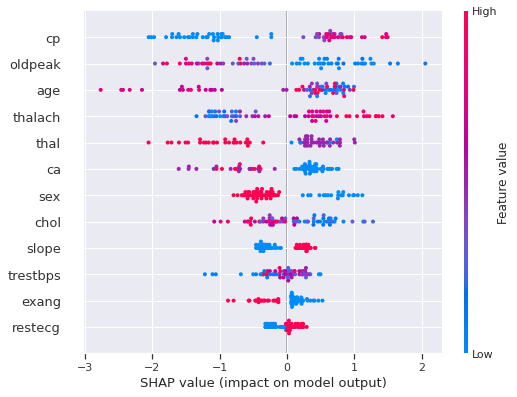

In [124]:
shap.summary_plot(shap_values, pd.DataFrame(X_test, columns=raw_train.columns.values))